In [118]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [119]:
# Dataset paths and settings
num_classes = 9
image_size = (128, 128)
batch_size = 256
epochs = 15
fine_tune_epochs = 5
class_names = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]

In [120]:
# --- Load Datasets ---
train_dataset = image_dataset_from_directory("kuvat/age/train", image_size=image_size, batch_size=batch_size)
val_dataset = image_dataset_from_directory("kuvat/age/val", image_size=image_size, batch_size=batch_size)
test_dataset = image_dataset_from_directory("kuvat/age/test", image_size=image_size, batch_size=batch_size)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)
test_dataset = test_dataset.prefetch(AUTOTUNE)


Found 6802 files belonging to 9 classes.
Found 1419 files belonging to 9 classes.
Found 1555 files belonging to 9 classes.


In [121]:
# --- Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
])


In [122]:
# --- Focal Loss ---
def sparse_categorical_focal_loss(gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.squeeze(y_true, axis=-1)
        y_true_one_hot = tf.one_hot(y_true, depth=y_pred.shape[-1])
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true_one_hot, y_pred)
        probs = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
        focal_loss = tf.pow(1.0 - probs, gamma) * cross_entropy
        return focal_loss
    return loss


In [123]:
# --- Build Model ---
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=(128, 128, 3))
x = layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

In [124]:
# --- Class Weights ---
labels = np.concatenate([y for x, y in train_dataset], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

In [125]:
# --- Callbacks ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

In [127]:
# --- Compile & Train ---
model.compile(optimizer='adam', loss=sparse_categorical_focal_loss(gamma=2.0), metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    class_weight=class_weights,
                    callbacks=callbacks)

Epoch 1/15
27/27 [==============================] - 38s 1s/step - loss: 2.2962 - accuracy: 0.2801 - val_loss: 1.7892 - val_accuracy: 0.3820 - lr: 0.0010
Epoch 2/15
27/27 [==============================] - 33s 1s/step - loss: 1.8758 - accuracy: 0.3989 - val_loss: 1.6865 - val_accuracy: 0.4257 - lr: 0.0010
Epoch 3/15
27/27 [==============================] - 34s 1s/step - loss: 1.7853 - accuracy: 0.4325 - val_loss: 1.6644 - val_accuracy: 0.4172 - lr: 0.0010
Epoch 4/15
27/27 [==============================] - 34s 1s/step - loss: 1.7441 - accuracy: 0.4465 - val_loss: 1.6170 - val_accuracy: 0.4341 - lr: 0.0010
Epoch 5/15
27/27 [==============================] - 33s 1s/step - loss: 1.7227 - accuracy: 0.4624 - val_loss: 1.6237 - val_accuracy: 0.4299 - lr: 0.0010
Epoch 6/15
27/27 [==============================] - 35s 1s/step - loss: 1.6926 - accuracy: 0.4772 - val_loss: 1.5805 - val_accuracy: 0.4679 - lr: 0.0010
Epoch 7/15
27/27 [==============================] - 34s 1s/step - loss: 1.6803 - a

In [128]:
# --- Fine-tune base model ---
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=sparse_categorical_focal_loss(gamma=2.0),
              metrics=['accuracy'])

model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=fine_tune_epochs,
          class_weight=class_weights,
          callbacks=callbacks)

Epoch 1/5
27/27 [==============================] - 56s 2s/step - loss: 1.8659 - accuracy: 0.4083 - val_loss: 1.6750 - val_accuracy: 0.3982 - lr: 1.0000e-04
Epoch 2/5
27/27 [==============================] - 46s 2s/step - loss: 1.6360 - accuracy: 0.4894 - val_loss: 1.4848 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 3/5
27/27 [==============================] - 45s 2s/step - loss: 1.5559 - accuracy: 0.5273 - val_loss: 1.5735 - val_accuracy: 0.4574 - lr: 1.0000e-04
Epoch 4/5
27/27 [==============================] - 45s 2s/step - loss: 1.5012 - accuracy: 0.5534 - val_loss: 1.3851 - val_accuracy: 0.5349 - lr: 1.0000e-04
Epoch 5/5
27/27 [==============================] - 44s 2s/step - loss: 1.4700 - accuracy: 0.5653 - val_loss: 1.3928 - val_accuracy: 0.5426 - lr: 1.0000e-04


In [129]:
# --- Evaluation ---
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")

7/7 [==============================] - 6s 766ms/step - loss: 1.3664 - accuracy: 0.5415
Test accuracy: 0.5415


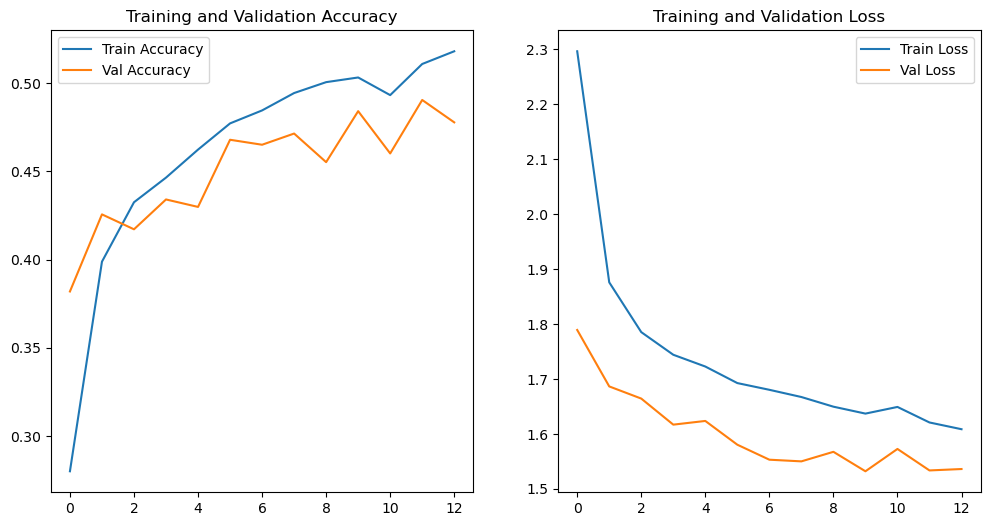

In [130]:
# --- Plot Accuracy/Loss ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

8/8 [==============================] - 2s 127ms/step


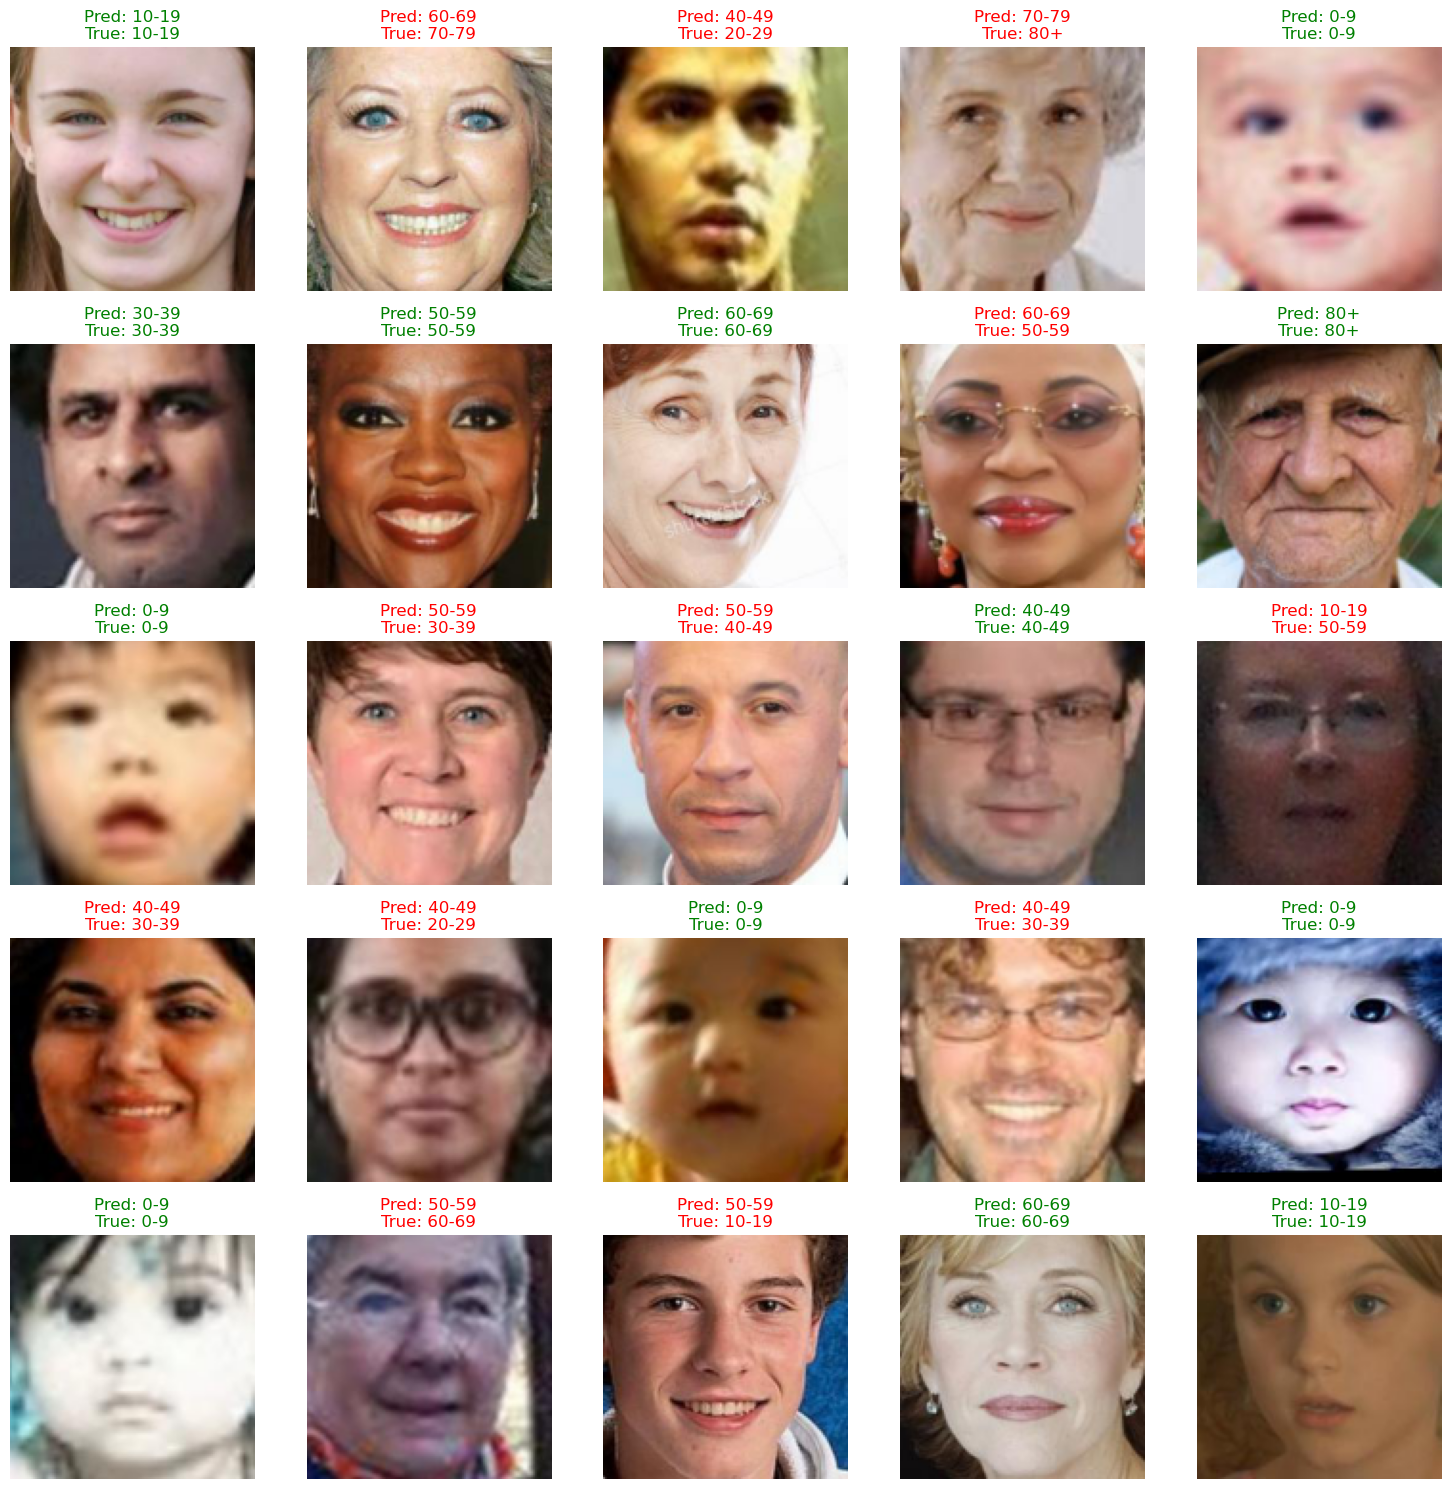

In [131]:
# --- Prediction Visualization ---
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [132]:
# --- Classification Report ---
y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 [==============================] - 1s 867ms/step

Classification Report:

              precision    recall  f1-score   support

         0-9       0.96      0.83      0.89       471
       10-19       0.47      0.53      0.50       186
       20-29       0.55      0.56      0.56       238
       30-39       0.29      0.13      0.18       162
       40-49       0.24      0.56      0.34       115
       50-59       0.44      0.33      0.38       155
       60-69       0.29      0.29      0.29        95
       70-79       0.29      0.47      0.36        68
         80+       0.61      0.35      0.45        65

    accuracy                           0.54      1555
   macro avg       0.46      0.45      0.44      1555
weighted avg       0.58      0.54      0.55      1555



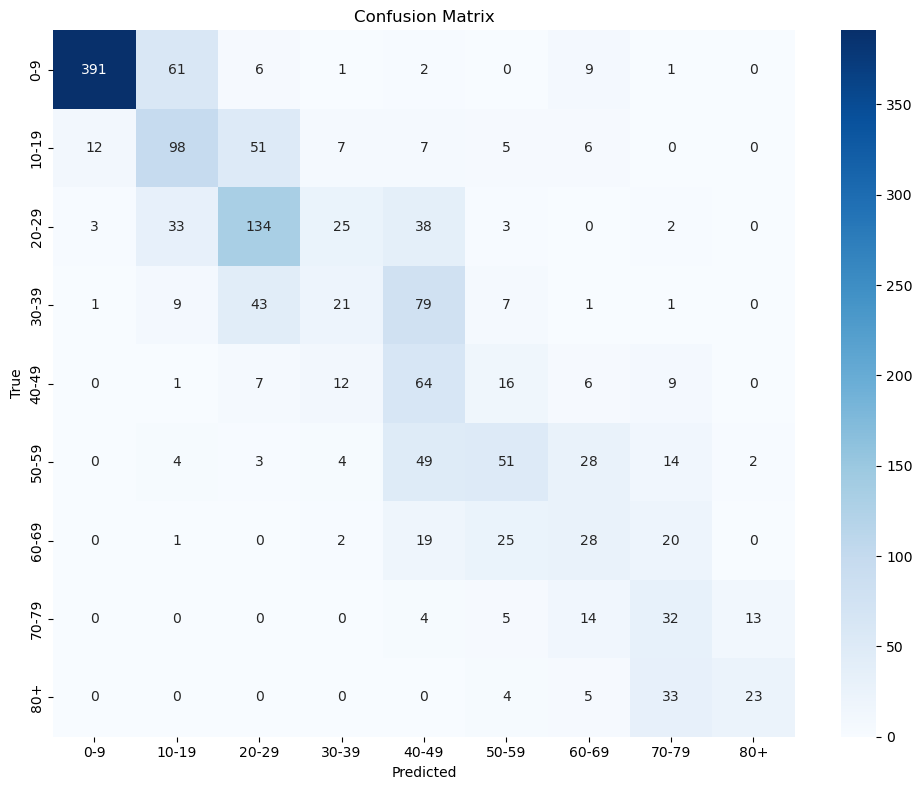

In [133]:
# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()